In [1]:
import os
import numpy as np
import matplotlib.pylab as plt

In [2]:
# find all TSeries folder
data_folder = '/home/yann.zerlaut/UNPROCESSED/' # folder all the TSeries-... folder
TSeries_folders = [df for df in os.listdir(data_folder) if ('TSeries' in df)]
print(TSeries_folders)

TSeries_folders = [os.path.join(data_folder, t) for t in TSeries_folders]

['TSeries-12232021-1316-002', 'TSeries-01182022-1548-001', 'TSeries-12232021-1316-005', 'TSeries-12212020-0951-001', 'TSeries-12232021-1316-006']


In [3]:

class Data:
    
    def __init__(self, TSeries_folder,
                 acq_freq=30.):
        """
        # load data
        - acq_freq in Hz
        """
        # load fluorescence of ROI neuropil
        F = np.load(os.path.join(TSeries_folder, 'suite2p', 'plane0', 'F.npy'))
        Fneu = np.load(os.path.join(TSeries_folder, 'suite2p', 'plane0', 'Fneu.npy'))
        iscell = np.load(os.path.join(TSeries_folder, 'suite2p', 'plane0', 'iscell.npy'))[:,0].astype(bool)
        # copmute time from acq freq
        self.t = np.arange(F.shape[1])/acq_freq
        # focusing only on selected cell
        self.F_ROI = F[iscell,:]
        self.F_neuropil = Fneu[iscell,:]
        self.nROI = self.F_ROI.shape[0]
        
    def compute_dFoF(self, neuropil_correction_factor=0., roi_index=None):
        """
        compute fluorescence variation with a neuropil correction set by the factor "neuropil_correction_factor"
        """
        if roi_index is None:
            roi_index = np.arange(self.nROI)
            
        if (neuropil_correction_factor>1) or (neuropil_correction_factor<0):
            print('/!\ neuropil_correction_factor has to be in the interval [0.,1]')
            print('neuropil_correction_factor set to 0 !')
            neuropil_correction_factor=0.
            
        new_F = self.F_ROI[roi_index,:]-neuropil_correction_factor*self.F_neuropil[roi_index,:]
        if np.sum(new_F<=0)>1:
            print(' /! \ TOO STRONG NEUROPIL CORRECTION FOR FACTOR = %.2f')
            print('           --> NEGATIVE FLUORESCENCE !!') 
            print('    --> returning zero array') 
            return 0*self.t
        else:
            if type(roi_index) in [list, range, np.array, np.ndarray]:
                return new_F/new_F[roi_index,:].min(axis=0)
            else:
                return new_F/new_F.min()
        
    # plot raw data
    def plot_raw(self, roi_index=0, tzoom=None, subsampling=1):
        """
        plot both roi and neuropil fluo for those data
        """
        if tzoom is None:
            tzoom = [0, self.t[-1]]
            
        fig, ax = plt.subplots(figsize=(10,2))
        
        time_cond = (self.t>=tzoom[0]) & (self.t<=tzoom[1])
        ax.plot(self.t[time_cond][::subsampling], self.F_ROI[roi_index, time_cond][::subsampling], label='ROI')
        ax.plot(self.t[time_cond][::subsampling], self.F_neuropil[roi_index, time_cond][::subsampling], label='neuropil')
        ax.legend()
        ax.set_xlabel('time (s)')
        ax.set_ylabel('fluo. (a.u.)')

    # plot fluorescence variations
    def plot_dFoF(self, 
                  roi_index=0, 
                  neuropil_correction_factor=0.,
                  factors=None,
                  tzoom=None, subsampling=1):
        """
        plot both roi and neuropil fluo for those data
        """
        if tzoom is None:
            tzoom = [0, self.t[-1]]
        
        if factors is None:
            factors = [neuropil_correction_factor]
            
        fig, ax = plt.subplots(figsize=(10,2))
        
        for nrp_factor in factors:
            dFoF = self.compute_dFoF(roi_index=roi_index, 
                                     neuropil_correction_factor=nrp_factor)
        
            time_cond = (self.t>=tzoom[0]) & (self.t<=tzoom[1])
            ax.plot(self.t[time_cond][::subsampling], dFoF[time_cond][::subsampling], 
                    label='Fneu factor=%.1f' % nrp_factor)
        ax.legend()
        ax.set_xlabel('time (s)')
        ax.set_ylabel('dF/F')

    def plot_dFoF_hist(self, 
                       roi_index=0, 
                       neuropil_correction_factor=0.,
                       factors=None):
        """
        plot dF/F hist
        """
        if factors is None:
            factors = [neuropil_correction_factor]
            
        fig, ax = plt.subplots(figsize=(4,2))
        
        for nrp_factor in factors:
            dFoF = self.compute_dFoF(roi_index=roi_index, 
                                     neuropil_correction_factor=nrp_factor)
            ax.hist(dFoF, bins=50, density=True, alpha=.8,
                    label='Fneu factor=%.1f' % nrp_factor)
        ax.legend(fontsize='small')
        ax.set_xlabel('time (s)')
        ax.set_ylabel('dF/F')

    def get_mean_sem_dFoF_over_cells(self, neuropil_correction_factor=0):
        dFoF = self.compute_dFoF(roi_index=np.arange(self.nROI), 
                                 neuropil_correction_factor=neuropil_correction_factor)
        return dFoF.mean(axis=1), dFoF.std(axis=1)

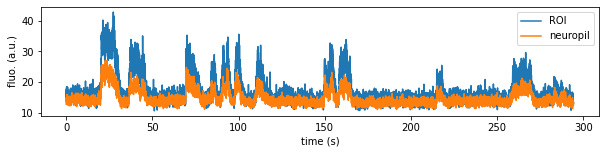

In [4]:
# let's load a datafile and look at the fluorescence
data = Data(TSeries_folders[1])
data.plot_raw(roi_index=2)

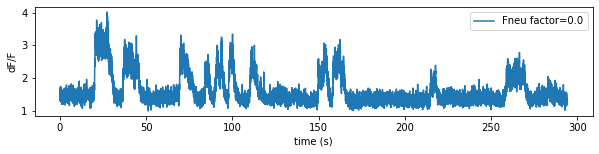

In [5]:
# plotting dF over F
data.plot_dFoF(roi_index=2, neuropil_correction_factor=0)

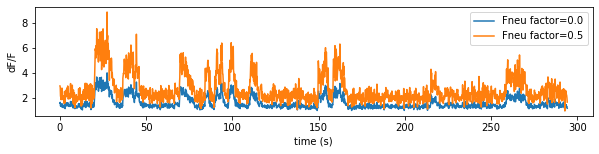

In [6]:
# looking at different dF over F for different correction factors
data.plot_dFoF(roi_index=2, factors=[0., 0.5], subsampling=5)

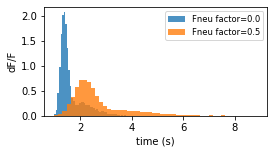

In [7]:
# histogram for that cell
data.plot_dFoF_hist(roi_index=2,factors=[0., 0.5], )

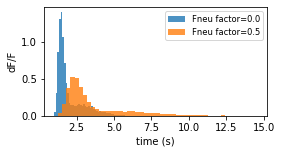

In [9]:
# for another cell
data.plot_dFoF_hist(roi_index=10,factors=[0., 0.5])

Text(0, 0.5, 'dF/F')

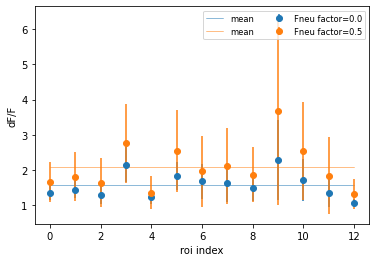

In [35]:
# mean and std for each cell
fig, ax = plt.subplots()
for i, factor in enumerate([0,0.5]):
    means, stds = data.get_mean_sem_dFoF_over_cells(neuropil_correction_factor=factor)
    ax.errorbar(np.arange(len(means)), means, yerr=stds, fmt='o',
                label='Fneu factor=%.1f' % factor, color=plt.cm.tab10(i))
    ax.plot([0,len(means)-1], np.mean(means)*np.ones(2), 
            lw=0.5, label='mean', color=plt.cm.tab10(i))
ax.legend(fontsize='small', ncol=2)
ax.set_xlabel('roi index')
ax.set_ylabel('dF/F')

In [ ]:
# now looping over files

Text(0, 0.5, 'mean dF/F')

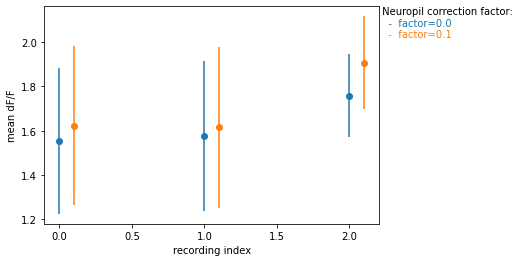

In [52]:
CORRECTION_FACTORS = [0, 0.1]

TSeries_folders = TSeries_folders[:3]

# mean and std for each cell
fig, ax = plt.subplots()
for t, df in enumerate(TSeries_folders):
    try:
        data = Data(df)
        for i, factor in enumerate(CORRECTION_FACTORS):
            means, _ = data.get_mean_sem_dFoF_over_cells(neuropil_correction_factor=factor)
            ax.errorbar([t+.1*i], [np.mean(means)], yerr=[np.std(means)], fmt='o',
                        color=plt.cm.tab10(i))
    except BaseException as be:
        print(be)
        print(' /!\ "%s" INVALID DATAFOLDER  ' % df)
        
ax.annotate(' Neuropil correction factor:', (1,1), xycoords='axes fraction', va='top')
for i, factor in enumerate(CORRECTION_FACTORS):
    ax.annotate((i+1)*'\n'+'   -  factor=%.1f' % factor, (1,1), 
                xycoords='axes fraction', color=plt.cm.tab10(i), va='top')
ax.set_xlabel('recording index')
ax.set_ylabel('mean dF/F')